In [59]:
import os
import pickle
from tqdm import tqdm
import sentencepiece as spm

In [60]:
source_folder = '/scratche/home/apoorv/repos/probe_kge/data/yago3-10'
! ls {source_folder}

dataset.yaml	  test.txt		   valid.del
entity_ids.del	  test_without_unseen.del  valid.txt
full.txt	  train.del		   valid_without_unseen.del
relation_ids.del  train_sample.del
test.del	  train.txt


In [69]:
fname = 'entity_ids.del'
entities = []
for line in open(os.path.join(source_folder, fname)):
    line = line.strip().split('\t')
    entities.append(line[1])
    
fname = 'relation_ids.del'
relations = []
for line in open(os.path.join(source_folder, fname)):
    line = line.strip().split('\t')
    relations.append(line[1])

In [62]:
def readTriples(fname):
    f = open(fname)
    triples = []
    for line in f:
        if line[-1] == '\n':
            line = line[:-1]
        triples.append(line.split('\t'))
    f.close()
    return triples

In [63]:
data = {}
splits = ['train', 'test', 'valid']
for split in splits:
    fname = os.path.join(source_folder, split + '.txt')
    data[split] = readTriples(fname)

In [64]:
data['train'][2]

['Toni_Kuivasto', 'isAffiliatedTo', 'Helsingin_Jalkapalloklubi']

In [68]:
from unidecode import unidecode

def normalizeRelation(rel):
    out = ""
    for c in rel:
        if c.isupper():
            out += ' ' + c.lower()
        else:
            out += c
    return out

def normalizeEntity(ent):
    ent = ent.replace('_', ' ')
    ent = unidecode(ent)
    return ent

In [70]:
relation_map = {}
for rel in relations:
    rel_processed = normalizeRelation(rel)
    relation_map[rel] = rel_processed

In [73]:
entity_map = {}
for ent in entities:
    ent_processed = normalizeEntity(ent)
    entity_map[ent] = ent_processed

In [80]:
def getUniqueMap(init_map):
    out_map = {}
    values = set()
    for key, value in init_map.items():
        if value not in values:
            out_map[key] = value
            values.add(value)
        else:
            id_to_append = 0
            new_value = value + ' ' + str(id_to_append)
            while(new_value in values):
                id_to_append += 1
                new_value = value + ' ' + str(id_to_append)
            out_map[key] = new_value
            values.add(new_value)
    assert len(init_map) == len(set(out_map.values()))
    return out_map

def mapTriple(triple, ent_map, rel_map):
    new_triple = [ent_map[t[0]], rel_map[t[1]], ent_map[t[2]]]
    return new_triple

In [76]:
uniq_ent_map = getUniqueMap(entity_map)

In [82]:
mapTriple(data['train'][0], uniq_ent_map, relation_map)

['Juan Pablo Raponi', 'plays for', 'Club Atletico River Plate']

In [83]:
out_folder = '/scratche/home/apoorv/transformer-kgc/data/yago3-10'
splits = ['train', 'test', 'valid']
for split in splits:
    fname = os.path.join(out_folder, split + '2.txt')
    f = open(fname, 'w')
    triples = data[split]
    for t in triples:
        t = mapTriple(t, uniq_ent_map, relation_map)
        head, relation, tail = t
        input = 'predict tail: {0} | {1} |'.format(head, relation)
        output = '{}'.format(tail)
        f.write(input + '\t' + output + '\n')
        
        input = 'predict head: {0} | {1} |'.format(tail, relation)
        output = '{}'.format(head)
        f.write(input + '\t' + output + '\n')
    f.close()

In [84]:
# create entity_strings.txt which is needed in evaluation code
strings_file_name = 'entity_strings2.txt'
f = open(os.path.join(out_folder, strings_file_name), 'w')
ents_uniq = set(uniq_ent_map.values())
for e in ents_uniq:
    f.write(e + '\n')
f.close()

In [85]:
vocab_size = 30000
sp = spm.SentencePieceTrainer.train(input='data/yago3-10/full2.txt', 
                                    model_prefix='yago_with_pad2', vocab_size=vocab_size, 
                                    pad_id=3,
#                                     character_coverage=1.0,
#                                user_defined_symbols=['<pad>'],
#                                     normalization_rule_name='identity',
                              )

In [87]:
sp = spm.SentencePieceProcessor(model_file='data/sentencepiece/yago_with_pad2.model')

In [88]:
sp['<pad>']

3

In [90]:
entities[:10]

['Chatou',
 'France',
 'Boo_Young-tae',
 'Yangju_Citizen_FC',
 'Toni_Kuivasto',
 'Helsingin_Jalkapalloklubi',
 'Josh_Smith_(soccer)',
 'Trinity_University_(Texas)',
 'Albrecht_Dürer',
 'Nuremberg']

In [92]:
lengths = []
for e in ents_uniq:
    encoded = sp.encode(e)
    lengths.append(len(encoded))

Text(0.5, 0, 'Tokenized lengths')

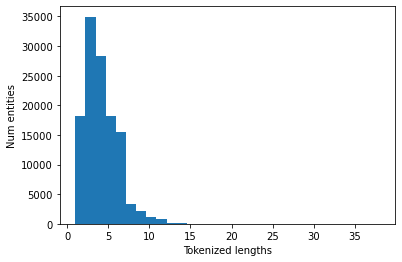

In [93]:
import matplotlib.pyplot as plt 

import numpy as np 

%matplotlib inline

# x = np.random.normal(size = 1000) 
x = lengths
plt.hist(x, bins=30) 

plt.ylabel('Num entities');
plt.xlabel('Tokenized lengths')

In [94]:
sp.encode('plays for')

[19, 13, 18]

In [35]:
from unidecode import unidecode
entities_ud = []
entities_ud_set = set()
for e in entities:
    ud_e = unidecode(e)
    entities_ud.append(ud_e)
    if ud_e in entities_ud_set:
        print(e, ud_e)
    else:
        entities_ud_set.add(ud_e)

University_of_Illinois_at_Urbana-Champaign University_of_Illinois_at_Urbana-Champaign
Hoang_Anh_Gia_Lai_F.C. Hoang_Anh_Gia_Lai_F.C.
Zurich Zurich
Toshirō_Mifune Toshiro_Mifune
Karl_Weierstrass Karl_Weierstrass
László_Bálint Laszlo_Balint
Sergio_Araujo Sergio_Araujo
Carlos_Tevez Carlos_Tevez
Polish-Lithuanian_Commonwealth Polish-Lithuanian_Commonwealth
Przemysl_II Przemysl_II
Christian_Groß Christian_Gross
Izmir Izmir
Münster Munster
Dalibor_Stevanovič Dalibor_Stevanovic
Jürgen_Gjasula Jurgen_Gjasula
Sócrates Socrates
Zlatko_Dedič Zlatko_Dedic
Antônio_Bezerra_Brandão Antonio_Bezerra_Brandao
Aleksander_Kwasniewski Aleksander_Kwasniewski
Sani_Bečirović Sani_Becirovic
Izmit Izmit
Ryukyu_Islands Ryukyu_Islands
Stanisław_Ulam Stanislaw_Ulam
Pantheon-Assas_University Pantheon-Assas_University
Quang_Binh_Province Quang_Binh_Province
Mures_County Mures_County
Braila Braila
San_Sebastian San_Sebastian
Ploiesti Ploiesti
Beja Beja
Zé_Antônio Ze_Antonio
San_Miguel_de_Tucumán San_Miguel_de_Tucuman
F

In [28]:
len(entities), len(set(entities))

(123182, 123182)

In [33]:
len(entities_ud), len(set(entities_ud))

(123182, 123145)